# Hypothesis Test 3

## Data Collection

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower

In the cells below, we are creating a connection to our PSQL databased named 'soccer'. This allows us to select data from certain tables in our database and turn them into dataframes that we can later join or merge in order to explore our data. 

In [2]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()
query = '''
SELECT *
FROM Country
;'''
cur.execute(query)

In [3]:
countries_data = cur.fetchall()
countries_df = pd.DataFrame(countries_data)
countries_df.columns = [i[0] for i in cur.description]
countries_df.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [4]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()
query = '''
SELECT *
FROM League
;'''
cur.execute(query)
league_data = cur.fetchall()
league_df = pd.DataFrame(league_data)
league_df.columns = [i[0] for i in cur.description]
league_df.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [5]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Match
;'''

cur.execute(query)

match_data = cur.fetchall()
match_df = pd.DataFrame(match_data)
match_df.columns = [i[0] for i in cur.description]

In [6]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Player_Attributes
;'''

cur.execute(query)

player_attrib_data = cur.fetchall()
player_attrib_df = pd.DataFrame(player_attrib_data)
player_attrib_df.columns = [i[0] for i in cur.description]


In [7]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team
;'''

cur.execute(query)

team_data = cur.fetchall()
team_df = pd.DataFrame(team_data)
team_df.columns = [i[0] for i in cur.description]


In [8]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team_Attributes
;'''

cur.execute(query)

team_attrib_data = cur.fetchall()
team_attrib_df = pd.DataFrame(team_attrib_data)
team_attrib_df.columns = [i[0] for i in cur.description]


In [9]:
player_df = pd.read_csv('player.csv')


 # HYPOTHESIS TEST 3: Defensive Aggression


- H0 (Null Hypothesis): there is no statistically significant difference in the defensive aggressiveness between the English and French soccer leagues. (mu_defenceaggression_english = mu_defenceaggression_french)
- HA (Alternative Hypothesis): there is no statistically significant difference in the defensive aggressiveness between the English and French soccer leagues. (mu_defenceaggression_english != mu_defenceaggression_french)

- Alpha = 0.05

##### Assumptions:
- Data is collected randomly
- Data is independent
- Data is approximately normally distributed

# Data Formatting

We had to make several merge and joins in order to compare the leagues. 
Below we merged the match data with the league_ids so that we can see which matches were played in each league

In [10]:
match_league_df = match_df.merge(league_df, left_on='league_id', right_on='id')

In [11]:
match_league_df['name'].value_counts()


Spain LIGA BBVA             3040
France Ligue 1              3040
England Premier League      3040
Italy Serie A               3017
Germany 1. Bundesliga       2448
Netherlands Eredivisie      2448
Portugal Liga ZON Sagres    2052
Poland Ekstraklasa          1920
Scotland Premier League     1824
Belgium Jupiler League      1728
Switzerland Super League    1422
Name: name, dtype: int64

Below we have join the team attribute dataframe(which holds team charatericics like defensive aggression and chance creations) with the names of the leagues in the match league dataframe. This gives us a dataframe containing teams, their attributes and the league that they play in. 

In [12]:
team_attrib_by_league=team_attrib_df.join(match_league_df['name'], on='team_api_id', how='left')

By examining the value counts of our dataframe, we can see that they are only two leagues with a decent amount of data. We would have liked to look at other leagues, but we are limited by our dataset.

In [13]:
defense = team_attrib_by_league[['defenceaggression', 'team_api_id', 'name']]
defense['name'].value_counts()

England Premier League      739
France Ligue 1              665
Poland Ekstraklasa           29
Portugal Liga ZON Sagres      8
Belgium Jupiler League        6
Name: name, dtype: int64

In order to extract the rows/matches of the teams in the two leagues we are exploring, we have to create slices of the dataframe that only hold data from each league.

In [14]:
#swiss_d = defense.loc[defense['defenseaggression'], 'name' == 'Switzerland Super League']
english_d = defense[defense['name'].str.contains("England")==True]
french_d = defense[defense['name'].str.contains("France")==True]


Numpy Arrays of Match/Defense Aggressiveness Data

In [15]:
english_array_df = english_d['defenceaggression']
english_array = np.array(english_array_df)
len(english_array)

739

In [16]:
french_array_df = french_d['defenceaggression']
french_array = np.array(french_array_df)
len(french_array)

665

## Two Sample Test Functions

In [17]:
def calc_variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

def calc_sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var1, var2 = calc_variance(sample1), calc_variance(sample2)
    return (var1 + var2) / ((n_1 + n_2) - 2)

def calc_twosample_tstatistic(expr, ctrl):
    expr_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    n_e, n_c = len(expr), len(ctrl)
    samp_var = calc_sample_variance(expr,ctrl)
    t = (expr_mean - ctrl_mean) / np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return t


# Power Testing for Sample Sizes

In [18]:
english_rat = sum(english_array)/len(english_array)
french_rat = sum(french_array)/len(french_array)
vareng = english_array.var()
varfren = french_array.var()

pooled_var = (len(english_array) * vareng + len(french_array) * varfren) / (len(english_array) + len(french_array))
diff = english_rat - french_rat
#std_442 = np.std(four42_df['442_win'])
#std_433= np.std(four33_df['433_win'])
d = diff / np.sqrt(pooled_var)
d

0.06987960501246691

English Minimun Sample Size

In [19]:
# Initialize parameters
effect = d
alpha = 0.05
power = 0.23
# ratio of 442wins which is 442win sum /442feat  sum
ratio = len(english_array)/len(french_array)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                             ratio=ratio, alpha=alpha)
print(f"The minimum sample size: {result}")
print(f"English Matches:{len(english_array)}")

The minimum sample size: 578.7407305441423
English Matches:739


French Minimum Sample Size

In [20]:
# Initialize parameters
effect = d
alpha = 0.05
power = 0.23
# ratio of 442wins which is 442win sum /442feat  sum
ratio = len(french_array)/len(english_array)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                             ratio=ratio, alpha=alpha)
print(f"The minimum sample size: {result}")
print(f"French Matches:{len(french_array)}")

The minimum sample size: 643.1419546964909
French Matches:665


## England Vs French Defensive Aggressiveness

Vizualing data for understanding

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


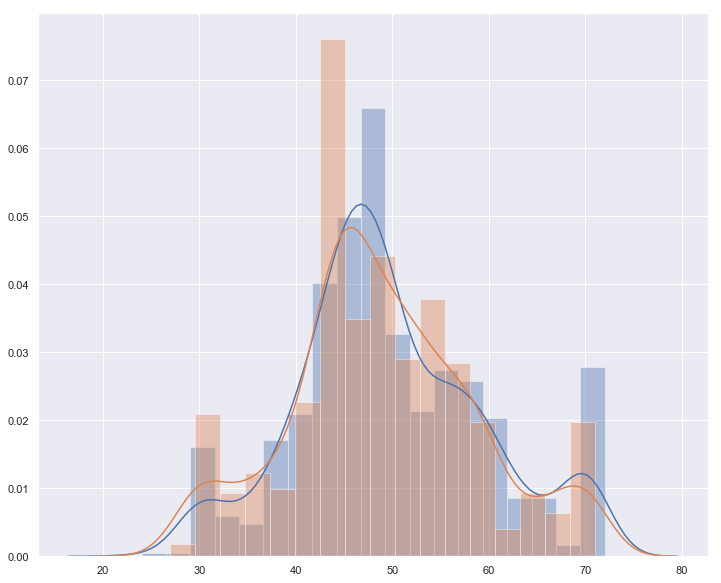

In [21]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(english_array) # Blue distribution
sns.distplot(french_array) # Green distribution

In order to run our test, we have to create samples. Create an empty list and randomly select 50 samples from our data. This allows our test to be as random as possible.

In [24]:
sample_means_english = []
for _ in range(50):
    sample_mean = np.random.choice(english_array,size=578).mean()
    sample_means_english.append(sample_mean)
len(sample_means_english)

sample_means_french = []
for _ in range(50):
    sample_mean = np.random.choice(french_array,size=643).mean()
    sample_means_french.append(sample_mean)
len(sample_means_french)

50

In [25]:
sample_means_english
sample_means_french

[48.72317262830482,
 49.259720062208395,
 49.58942457231726,
 49.34836702954899,
 49.03265940902022,
 49.27993779160187,
 49.01866251944013,
 49.21772939346812,
 49.309486780715396,
 49.262830482115085,
 49.36547433903577,
 49.40746500777605,
 48.78693623639191,
 48.5692068429238,
 49.11975116640747,
 48.65629860031104,
 49.01088646967341,
 49.11819595645412,
 48.788491446345255,
 48.917573872472786,
 49.102643856920686,
 49.30326594090202,
 48.98444790046656,
 48.968895800933126,
 49.292379471228614,
 48.748055987558324,
 48.89424572317263,
 49.15552099533437,
 49.02177293934681,
 49.026438569206846,
 48.88180404354588,
 49.273716951788494,
 48.367029548989116,
 49.346811819595644,
 48.82892690513219,
 48.90202177293935,
 48.67807153965786,
 49.077760497667185,
 48.81181959564541,
 48.52566096423017,
 49.07931570762053,
 48.59097978227061,
 48.80248833592535,
 48.92846034214619,
 48.59875583203733,
 49.27838258164852,
 48.6407465007776,
 48.64541213063764,
 48.12597200622084,
 49.1710

In [26]:
t_stat = calc_twosample_tstatistic(sample_means_english, sample_means_french)

t_stat

10.50380686701404

# Type Something

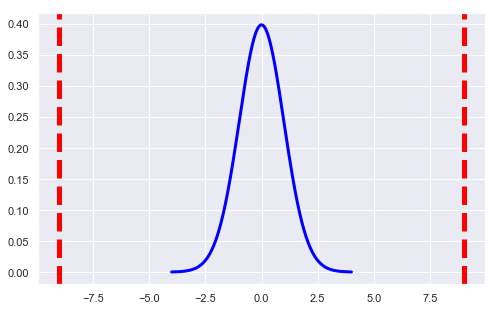

In [55]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='blue')

    ax.axvline(t_stat, color='red', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='red', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(sample_means_english)
n_experimental = len(sample_means_french)
visualize_t(t_stat, n_control, n_experimental)

We use Sklearn here to double check that our math was correct.

In [28]:
stats.ttest_ind(sample_means_english, sample_means_french)

Ttest_indResult(statistic=10.50380686701404, pvalue=9.788453177905179e-18)

## Conclusion: Hypothesis 3
#### According to our p-value, we will reject the null hypothesis, accept the alternative hypothesis and conclude that there is a statistical difference in the defensive aggression of teams from the English and French leagues. The caveat with our test is that we can only claim our conclusion with a power of 23%, this was in part because the data set we were given was too small and within the time constraints of our project we were unable to collect more.

# Hypothesis 4: Chance Cross Creation

- H0 (Null Hypothesis): there is no statistically significant difference in the chance of cross creation between the English and French soccer leagues. (mu_defenceaggression_english = mu_defenceaggression_french)
- HA (Alternative Hypothesis): there is no statistically significant difference in the chance of cross creation between the English and French soccer leagues. (mu_defenceaggression_english != mu_defenceaggression_french)

- Alpha = 0.05

##### Assumptions:
- Data is collected randomly
- Data is independent
- Data is approximately normally distributed

In the cell below, we are using the value counts feature to check that our data is ready and usable for our test. 

In [30]:
chance_creation = team_attrib_by_league[['chancecreationshooting', 'team_api_id', 'name']]
chance_creation['name'].value_counts()

England Premier League      739
France Ligue 1              665
Poland Ekstraklasa           29
Portugal Liga ZON Sagres      8
Belgium Jupiler League        6
Name: name, dtype: int64

Using a boolean to extract only rows specific to our experiment from our data frame.

In [31]:
english_cross = chance_creation[chance_creation['name'].str.contains("England")==True]
french_cross = chance_creation[chance_creation['name'].str.contains("France")==True]

Casting our dataframe series to a numpy array so that we can manipulate it easily.

In [32]:
english_cross_array = english_cross['chancecreationshooting']
english_array = np.array(english_cross_array)
len(english_cross_array)

french_cross_array = french_cross['chancecreationshooting']
french_array = np.array(french_cross_array)
len(french_cross_array)

665

#### Cohen's D
"Cohen's d is an effect size used to indicate the standardised difference between two means. It can be used, for example, to accompany reporting of t-test and ANOVA results. It is also widely used in meta-analysis. Cohen's d is an appropriate effect size for the comparison between two means."

Calculate Cohen's D using the values gathered from our data.

In [36]:
english_cr_ratio = sum(english_cross_array)/len(english_cross_array)
french_cr_ratio = sum(french_cross_array)/len(french_cross_array)
vareng_cross = english_cross_array.var()
varfren_cross = french_cross_array.var()

pooled_var_cross = (len(english_cross_array) * vareng_cross + len(french_cross_array) * varfren_cross) / (len(english_cross_array) + len(french_cross_array))
diff = english_cr_ratio - french_cr_ratio
#std_442 = np.std(four42_df['442_win'])
#std_433= np.std(four33_df['433_win'])
cross_d = diff / np.sqrt(pooled_var_cross)
cross_d


0.07754019860167374

In [45]:
# Initialize parameters
effect = cross_d
alpha_cross = 0.05
power_cross = 0.30
# ratio of 442wins which is 442win sum /442feat  sum
ratio_cross = len(english_cross_array)/len(french_cross_array)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power_cross, nobs1=None,
                             ratio=ratio_cross, alpha=alpha_cross)
print(f"The minimum sample size: {result}")
print(f"English Matches:{len(english_array)}")

The minimum sample size: 651.2127888781062
English Matches:739


In [56]:
# Initialize parameters
effect = cross_d
alpha_cross = 0.05
power_cross = 0.30
# ratio of 442wins which is 442win sum /442feat  sum
ratio_cross = len(french_cross_array)/len(english_cross_array)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power_cross, nobs1=None,
                             ratio=ratio_cross, alpha=alpha_cross)
print(f"The minimum sample size: {result}")
print(f"French Matches:{len(english_array)}")

The minimum sample size: 723.6785745202167
French Matches:739


Generate a list of sample means using the bootstrapping method. Bootstrapping allows assigning measures of accuracy (defined in terms of bias, variance, confidence intervals, prediction error or some other such measure) to sample estimates. This technique allows estimation of the sampling distribution of almost any statistic using random sampling methods. This ensures our data for the 2-sample T-test is randomly collected, independent, and approximately normally distributed. 

In [46]:
sample_means_english_cross = []
for _ in range(50):
    sample_mean = np.random.choice(english_cross_array,size=651).mean()
    sample_means_english_cross.append(sample_mean)
len(sample_means_english_cross)

sample_means_french_cross= []
for _ in range(50):
    sample_mean = np.random.choice(french_cross_array,size=723).mean()
    sample_means_french_cross.append(sample_mean)
len(sample_means_french_cross)

50

Using the function ```calc_twosample_tstatistic``` to calculte our T-Stat

In [47]:
t_stat = calc_twosample_tstatistic(sample_means_english_cross, sample_means_french_cross)

t_stat

9.025836931239345

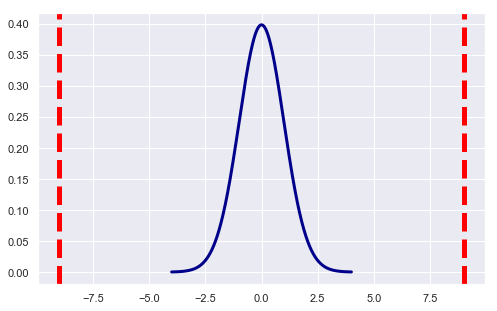

In [57]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkblue')

    ax.axvline(t_stat, color='red', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='red', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(sample_means_english_cross)
n_experimental = len(sample_means_french_cross)
visualize_t(t_stat, n_control, n_experimental)

Again, using Sklearn to confirm that our math and functions are the same

In [49]:
sk_test = stats.ttest_ind(sample_means_english_cross, sample_means_french_cross)
sk_test

Ttest_indResult(statistic=9.025836931239345, pvalue=1.572627487724217e-14)

## Conclusion: Hypothesis 4
#### According to our p-value, we will reject the null hypothesis, accept the alternative hypothesis and conclude that there is a statistical difference in the chance of cross creation  between teams in the English and French leagues. The caveat with our test is that we can only claim our conclusion with a power of 30%, this was in part because the data set we were given was too small and within the time constraints of our project we were unable to collect more.